# Connectivity Classifier

Steps:
- Perform parcellation and extract time series
- Aggregate region-level time series into network-level time series (optional)
- Measure connectivity matrix and vectorize it
- Grid search for optimal parcellation
- Calculate cross-validated scores
- Permutation testing
- Learning curve analysis


In [204]:
%reload_ext autoreload
%autoreload 3

from copy import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygal as pg
import seaborn as sns
import xarray as xr
from python.acnets.pipeline import (ConnectivityExtractor,
                                    ConnectivityVectorizer, NetworkAggregator,
                                    Parcellation)
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, StratifiedShuffleSplit,
                                     permutation_test_score)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC
from tqdm import tqdm


In [205]:
def extract_connectivity(subjects=None,
          atlas='gordon2014_2mm',
          connectivity='correlation',
          aggregate_networks=True):
    """Parcellate regions, aggregate networks, and extract connectivity."""

    p = Parcellation(atlas)
    n = NetworkAggregator(p.labels_)
    c = ConnectivityExtractor(connectivity)

    if aggregate_networks:
        conn = make_pipeline(p, n, c).fit_transform(subjects)
        nodes = n.networks_
    else:
        conn = make_pipeline(p, c).fit_transform(subjects)
        nodes = p.labels_.index.to_list()

    conn_dataset = xr.DataArray(
        conn,
        coords={'subject': p.dataset_['subject'],
                'node': nodes},
        dims=['subject', 'node', 'node'],
        name='connectivity')

    # select only queried subjects
    if subjects is not None:
        subjects_1d = subjects.reshape(-1).tolist()
        conn_dataset = conn_dataset.sel(dict(subject=subjects_1d))

    return conn_dataset


def mock_extract_connectivity(subjects=None,
        atlas='gordon2014_2mm',
        connectivity='correlation',
        aggregate_networks=True):
    n_features_dict = {
        ('gordon2014_2mm', True): 13,
        ('gordon2014_2mm', False): 333,
        ('dosenbach2010', True): 6,
        ('dosenbach2010', False): 160,
        ('difumo_64_2mm', True): 7,
        ('difumo_64_2mm', False): 64,
    }

    n_features = n_features_dict[(atlas, aggregate_networks)]

    X_mock = np.random.rand(len(subjects), n_features, n_features)
    return X_mock

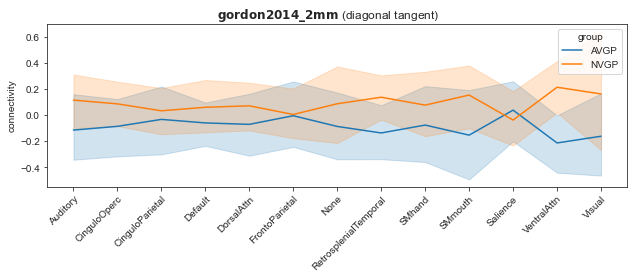

In [701]:
_atlas = 'gordon2014_2mm'
_connectivity = 'tangent'

conn_dataset = extract_connectivity(atlas=_atlas, connectivity=_connectivity)
subjects = conn_dataset.coords['subject'].values
subject_groups = np.array([s[:4] for s in subjects])
conn_vec = ConnectivityVectorizer(only_diagonal=True).fit_transform(conn_dataset)

plotting_data = pd.DataFrame(conn_vec, columns=conn_dataset.coords['node'].values)
plotting_data['group'] = subject_groups

plotting_data = plotting_data.melt(
    id_vars=['group'],
    var_name='network',
    value_name='connectivity')

# df['group_mean'] = df.groupby(['network'])['connectivity'].transform('mean')
# df.sort_values(by='group_mean', ascending=False, inplace=True)

n_networks = plotting_data['network'].nunique()

_, ax = plt.subplots(figsize=(n_networks * .8, 3))
sns.lineplot(data=plotting_data, x='network', y='connectivity', hue='group', sort=False)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

_atlas = _atlas.replace('_','\_')
plt.suptitle(f'$\\bf{{{_atlas}}}$ (diagonal {_connectivity})', y=.96)
plt.xlabel('')
plt.show()

In [ ]:
# TODO plot timeseties (avgp vs nvgp)


In [207]:

def fit_chance_grid(grid):

    chance_pipe  = Pipeline([
        ('connectivity', FunctionTransformer(mock_extract_connectivity)),
        # ('vectorize', ConnectivityVectorizer()),
        # ('select', SelectFromModel(LinearSVC(C=5, max_iter=100000))),
        # ('zv', VarianceThreshold(threshold=0)),
        ('dummy', DummyClassifier(strategy='stratified'))
    ])

    chance_params = {
        'connectivity__kw_args': grid.cv_results_['param_connectivity__kw_args']
    }

    subjects = extract_connectivity().coords['subject'].values
    groups = np.array([s[:4] for s in subjects])

    X = subjects.reshape(-1, 1)
    y = groups

    cv = copy(grid.cv)
    cv.n_splits = 100

    chance_grid = GridSearchCV(chance_pipe,
                               chance_params,
                               verbose=0,
                               cv=cv,
                               scoring=grid.scoring)

    chance_grid.fit(X, y)
    return chance_grid


/var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/ipykernel_72902/1030747559.py:49: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x137133e50> has a label of '_average' which cannot be automatically added to the legend.
  ax.legend(['average', '95% CI', '_average', 'chance'],


<Figure size 432x288 with 0 Axes>

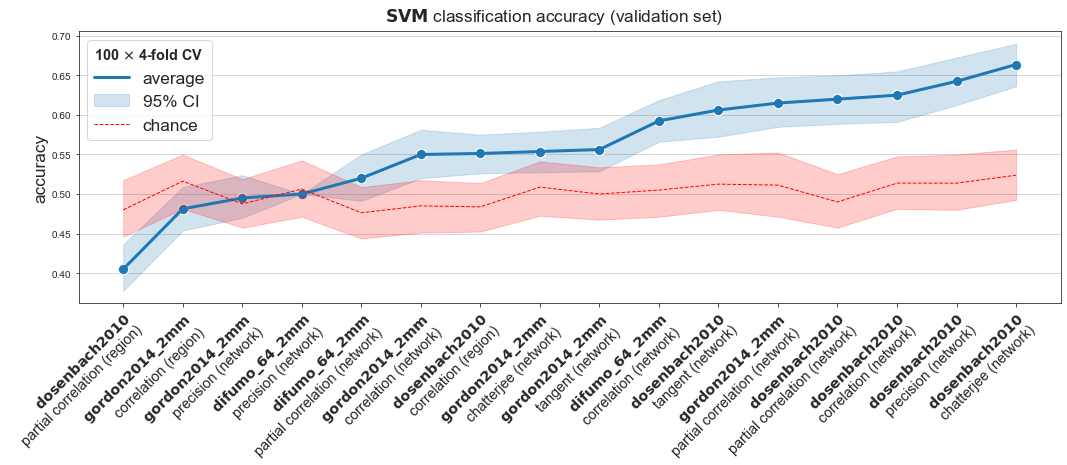

In [235]:
def extract_grid_test_scores(grid, score_name):
    results = grid.cv_results_
    n_splits = grid.cv.get_n_splits()

    param_names = []
    for param in results['param_connectivity__kw_args']:
        atlas = param['atlas'].replace('_','\_')
        connectivity = param['connectivity']
        feature = 'network' if param['aggregate_networks'] else 'region' 
        param_names.append(f'$\\bf{{{atlas}}}$\n{connectivity} ({feature})')

    cv_scores = []
    for i in range(n_splits):
        scores = results[f'split{i}_test_score']
        cv_scores.extend(list(zip(param_names, scores)))

    test_results  = pd.DataFrame(cv_scores, columns=['parcellation', score_name])
    test_results['mean_score'] = test_results.groupby('parcellation')[score_name].transform(
        np.mean)
    return test_results, param_names

def plot_grid_search_results(grid, chance_grid=None, score_name='accuracy'):
    sns.set_style('ticks')
    sns.despine()

    n_splits = grid.cv.get_n_splits()
    n_folds = int(1/grid.cv.test_size)
    test_scores, param_labels = extract_grid_test_scores(grid, score_name)

    test_scores.sort_values('mean_score', ascending=False, inplace=True)
    # DEBUG print(test_results.groupby('parcellation').min())

    _, ax = plt.subplots(figsize=(len(param_labels) * 1.1, 5))
    sns.lineplot(data=test_scores.iloc[::-1], x='parcellation', y=score_name,
                #  ci='sd',
                 lw=3, sort=False, ax=ax)
    sns.scatterplot(data=test_scores.iloc[::-1], x='parcellation', y='mean_score', marker='o', s=100,ax=ax)

    if chance_grid is None:
        # ax.axhline(.5, linestyle='--', color='red')
        pass
    else:
        chance_scores,_ = extract_grid_test_scores(chance_grid, score_name)
        sns.lineplot(data=chance_scores, x='parcellation', y=score_name,
                     ls='--', color='red',
                    #  ci='sd',
                     lw=1, ax=ax)

    ax.legend(['average', '95% CI', '_average', 'chance'],
                    title_fontproperties={'weight':'bold', 'size':'x-large'},
                    prop={'size':'xx-large'},
                    title=f'{n_splits} $\\times$ {n_folds}-fold CV')
    ax.get_legend()._legend_box.align = 'left'
    ax.set_xlabel('')
    ax.set_ylabel('accuracy', fontsize='xx-large')
    plt.xticks(rotation=45, ha='right', fontsize='x-large', rotation_mode='anchor')
    plt.suptitle('$\\bf{SVM}$ classification accuracy (validation set)', fontsize='xx-large', y=.95)
    plt.grid(axis='y')

    # table = plt.table(cellText=[['s','s2','s3','s4','s5'],['s','s2','s','s','s']],
    #                   rowLabels=['atlas','connectivity'],
    #                   rowColours=['lightgreen','gray'],
    #                 #   colLabels=['1','2'],
    #                 colLoc=['center','center'],
    #                   loc='bottom')

    plt.show()

plot_grid_search_results(grid, fit_chance_grid(grid))

Fitting 100 folds for each of 2 candidates, totalling 200 fits
[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=   0.2s
[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=   0.2s
[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=   0.2s
[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=   0.2s
[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=   0.2s
[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=   0.2s
[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True

The handle <matplotlib.collections.PathCollection object at 0x14d177280> has a label of '_average' which cannot be automatically added to the legend.


<Figure size 432x288 with 0 Axes>

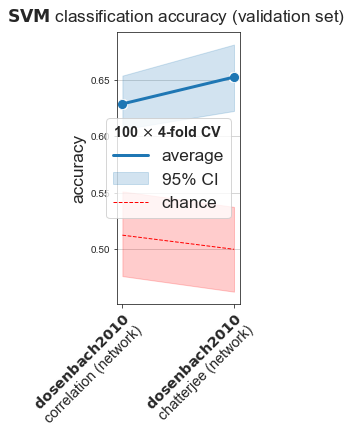

In [558]:
pipe  = Pipeline([
    ('connectivity', FunctionTransformer(extract_connectivity)),
    ('vectorize', ConnectivityVectorizer()),
    # ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('select', SelectFromModel(LinearSVC(C=5, max_iter=100000))),
    # ('zv', VarianceThreshold(threshold=0)),
    # ('svm', SVC(kernel='linear', probability=True))
    ('svm', LinearSVC(C=.1, max_iter=100000))
    # ('rfc', RandomForestClassifier())
])


params = {
    'connectivity__kw_args': [
        
        # dict(atlas='gordon2014_2mm', connectivity='correlation', aggregate_networks=False),
        # dict(atlas='gordon2014_2mm', connectivity='tangent', aggregate_networks=False),
        # dict(atlas='gordon2014_2mm', connectivity='partial correlation', aggregate_networks=False),

        # dict(atlas='gordon2014_2mm', connectivity='correlation', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='tangent', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='precision', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='partial correlation', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='chatterjee', aggregate_networks=True),

        # dict(atlas='dosenbach2010', connectivity='correlation', aggregate_networks=False),
        # dict(atlas='dosenbach2010', connectivity='tangent', aggregate_networks=False),
        # dict(atlas='dosenbach2010', connectivity='partial correlation', aggregate_networks=False),

        dict(atlas='dosenbach2010', connectivity='correlation', aggregate_networks=True),
        # dict(atlas='dosenbach2010', connectivity='tangent', aggregate_networks=True),
        # dict(atlas='dosenbach2010', connectivity='precision', aggregate_networks=True),
        # dict(atlas='dosenbach2010', connectivity='partial correlation', aggregate_networks=True),
        dict(atlas='dosenbach2010', connectivity='chatterjee', aggregate_networks=True),

        # dict(atlas='difumo_64_2mm', connectivity='correlation', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='tangent', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='precision', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='partial correlation', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='chatterjee', aggregate_networks=True)

    ],
    # 'select__estimator__C': [0.1, .3, .5, 1, 3, 5],
    # 'svm__C': [0.1, .3, .5, 1, 3, 5],
    # 'svm__kernel': ['linear', 'rbf'],
}

subjects = extract_connectivity().coords['subject'].values
groups = np.array([s[:4] for s in subjects])

X = subjects.reshape(-1, 1)
y = groups

cv = StratifiedShuffleSplit(n_splits=100, test_size=0.25)

grid = GridSearchCV(pipe, params, verbose=2, cv=cv, scoring='accuracy')
grid.fit(X, y)
print('best estimator:', grid.best_estimator_)
plot_grid_search_results(grid, fit_chance_grid(grid))

The handle <matplotlib.collections.PathCollection object at 0x14c323be0> has a label of '_average' which cannot be automatically added to the legend.


<Figure size 432x288 with 0 Axes>

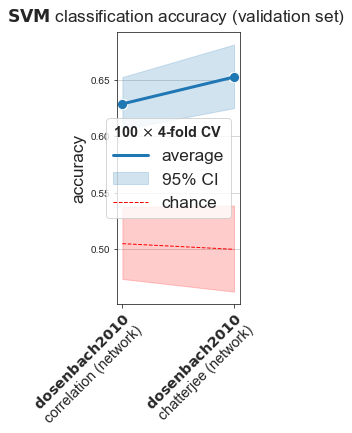

In [559]:
plot_grid_search_results(grid, fit_chance_grid(grid))

In [560]:
from sklearn.calibration import CalibratedClassifierCV
# best_clf = CalibratedClassifierCV(grid.best_estimator_, cv=cv).fit(X, y)
best_clf = grid.best_estimator_

## Permutation testing

In [239]:
# DEBUG
# grid.best_estimator_.named_steps['select'].estimator_.coef_
obs_score, perm_scores, pvalue = permutation_test_score(
    grid.best_estimator_,
    X, y,
    scoring='accuracy',
    n_permutations=100,
    n_jobs=-1,
    cv=cv,
    verbose=3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.6min finished


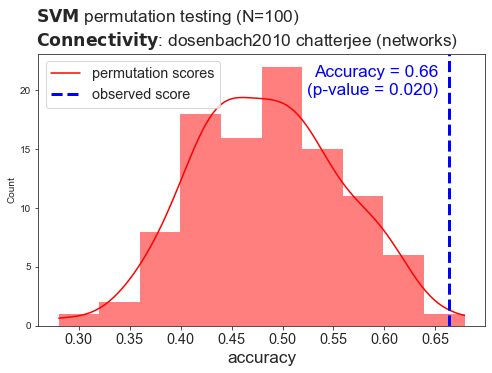

In [257]:
atlas = grid.best_estimator_.named_steps['connectivity'].kw_args['atlas']
connectivity = grid.best_estimator_.named_steps['connectivity'].kw_args['connectivity']
aggregated = grid.best_estimator_.named_steps['connectivity'].kw_args['aggregate_networks']
feature_name = 'networks' if aggregated else 'regions'

_, ax = plt.subplots(figsize=(8,5))
g = sns.histplot(perm_scores, kde=True, ax=ax, color='red', lw=0)
ax.axvline(obs_score, ls='--', color='blue', lw=3)
plt.xlabel('accuracy', fontsize='xx-large')
plt.xticks(fontsize='x-large')
ax.text(x=obs_score - .01,
        y=ax.get_ylim()[1] * .85,
        ha='right',
        color='blue',
        s=f'Accuracy = {obs_score:.2f}\n(p-value = {pvalue:.3f})', fontsize='xx-large')

plt.suptitle('$\\bf{SVM}$ permutation testing (N=100)\n'
             f'$\\bf{{Connectivity}}$: {atlas} {connectivity} ({feature_name})',
             ha='left',
             x = 0.12,
             y=1.01, fontsize='xx-large')
plt.legend(['permutation scores', 'observed score'], loc='upper left', fontsize='x-large')
plt.show()

## Permutation Importance

In [350]:
def get_feature_labels(atlas, connectivity, aggregate_networks):
    sep =  ' \N{left right arrow} '

    conn_ds = extract_connectivity(None, atlas, connectivity, aggregate_networks)
    networks = conn_ds.coords['node'].values
    feature_labels = pd.DataFrame(
        np.zeros((networks.shape[0], networks.shape[0])),
        columns=networks, index=networks)
    feature_labels = feature_labels.stack().to_frame().apply(lambda x:
        sep.join(x.name) if x.name[0] != x.name[1] else x.name[0],
        axis=1).unstack()
    return feature_labels

# lbls = get_feature_labels('gordon2014_2mm', 'tangent', True)
# ConnectivityVectorizer().fit_transform(lbls.values)

In [ ]:
from sklearn.inspection import permutation_importance

perm_imp_pipe  = Pipeline([
    # ('select', SelectFromModel(LinearSVC(C=5, max_iter=100000))),
    # ('zv', VarianceThreshold(threshold=0)),
    ('svm', LinearSVC(C=.1, max_iter=100000))
])

cv = StratifiedShuffleSplit(n_splits=100, test_size=0.25)

perm_imp_dataset = extract_connectivity(None, atlas, connectivity, aggregate_networks=aggregated)

X = perm_imp_dataset.values
X = ConnectivityVectorizer().fit_transform(X)


feature_names = get_feature_labels(atlas, connectivity, aggregated)
feature_names = ConnectivityVectorizer().fit_transform(feature_names.values)


perm_imp_mean_cv = []
for train, test in tqdm(cv.split(X,y), total=cv.get_n_splits(X,y)):
    perm_imp_pipe.fit(X[train], y[train])
    perm_imp_result = permutation_importance(perm_imp_pipe, X[test], y[test], 
                                            n_repeats=1000,
                                            scoring='accuracy', n_jobs=-1)
    perm_imp_mean_cv.append(perm_imp_result.importances_mean)

perm_imp_mean_df = pd.DataFrame(perm_imp_mean_cv, columns=feature_names)


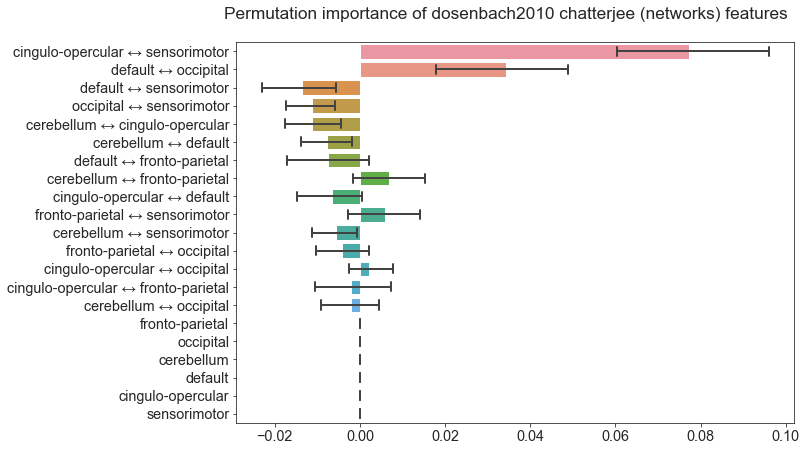

In [692]:
# sort by mean importance
sorted_columns = perm_imp_mean_df.mean(axis=0).abs().sort_values().index
sorted_columns = np.flip(sorted_columns)
perm_imp_mean_df = perm_imp_mean_df[sorted_columns]

atlas  = 'dosenbach2010'
connectivity='chatterjee'
aggregated=True
feature_name = 'networks' if aggregated else 'regions'

_, ax = plt.subplots(1,1,figsize=(10,7))
sns.barplot(
    data=perm_imp_mean_df,
    orient='horizontal',
    capsize=.5,
    errwidth=2,
    ax=ax
)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.suptitle(f'Permutation importance of {atlas} {connectivity} ({feature_name}) features', fontsize='xx-large', y=.95)
plt.show()

## SHAP

In [942]:
# SHAP
import shap

shap_values_cv = []
X_test_indices_cv = []
y_test_cv = []
y_pred_cv = []
expected_value_cv = []

from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=100)

subjects = extract_connectivity().coords['subject'].values
groups = np.array([s[:4] for s in subjects])

X = subjects.reshape(-1, 1)
y = groups

atlas  = 'dosenbach2010'
connectivity='chatterjee'
aggregated=True
feature_name = 'networks' if aggregated else 'regions'

feature_names= get_feature_labels(atlas, connectivity, aggregated)
feature_names = ConnectivityVectorizer().fit_transform(feature_names.values)

from sklearn.preprocessing import LabelEncoder
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)


n_splits = cv.get_n_splits(X, y)

shap_pipe  = Pipeline([
    ('connectivity', FunctionTransformer(extract_connectivity, kw_args={'atlas':atlas, 'connectivity':connectivity, 'aggregate_networks':aggregated})),
    ('vectorize', ConnectivityVectorizer()),
    # ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('select', SelectFromModel(LinearSVC(C=5, max_iter=100000))),
    # ('svm', SVC(kernel='linear', probability=True))
    # ('rfc', RandomForestClassifier())
])


for train, test in tqdm(cv.split(X, y), total=n_splits):

    X_train_vec = shap_pipe.fit_transform(X[train], y[train])
    X_test_vec = shap_pipe.fit_transform(X[test], y[test])

    # train the model
    model = grid.best_estimator_.named_steps['svm'].fit(X_train_vec, y[train])
    y_pred = model.predict(X_test_vec)

    explainer = shap.Explainer(
        model.predict, X_train_vec,
        feature_names=feature_names,
        # algorithm='tree',
        # approximate=True,
        # model_output='raw',
        # feature_perturbation='tree_path_dependent',
        # feature_perturbation='interventional',
    )

    shap_values = explainer(X_test_vec)#, check_additivity=True)

    shap_values_cv.append(shap_values)
    # expected_value_cv.append(explainer.expected_value)
    X_test_indices_cv.append(test)
    y_test_cv.append(y[test])
    y_pred_cv.append(y_pred)

100%|██████████| 400/400 [02:35<00:00,  2.58it/s]


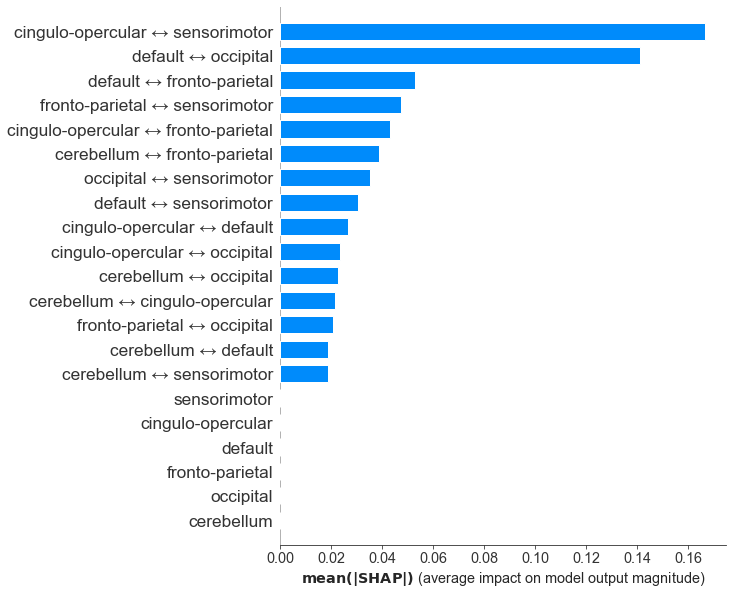

dosenbach2010 chatterjee


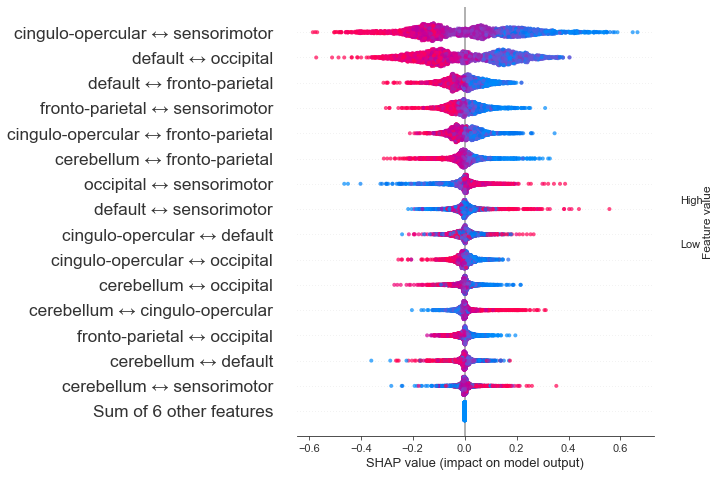

In [943]:
# merge CV data
X = subjects.reshape(-1, 1)
X_test = pd.DataFrame(X[np.hstack(X_test_indices_cv)], columns=['subject'])
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

# merge CV SHAPs
shap_values = shap.Explanation(
  values = np.vstack([sh.values for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=shap_values_cv[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)

from copy import deepcopy

shap.summary_plot(shap_values, max_display=21, show=False, plot_type='bar')
plt.yticks(fontsize='xx-large')
plt.xticks(fontsize='x-large')
plt.xlabel('$\\bf{mean(|SHAP|)}$ (average impact on model output magnitude)',fontsize='x-large')
# plt.suptitle('SHAP summary plot for {} {} ({})'.format(atlas, connectivity, feature_name), fontsize='xx-large', y=.92)
plt.show()
shap.plots.beeswarm(deepcopy(shap_values), max_display=16, alpha=.7, show=False)
plt.yticks(fontsize='xx-large')
print(atlas,connectivity)
plt.show()

In [949]:
# shap.force_plot(.5, shap_values[0])
shap.initjs()
shap.plots.force(.5, shap_values.values[0], feature_names=feature_names)

gordon2014_2mm partial correlation
[5, 3, 3, 4, 3, 3, 4, 4, 3, 3]


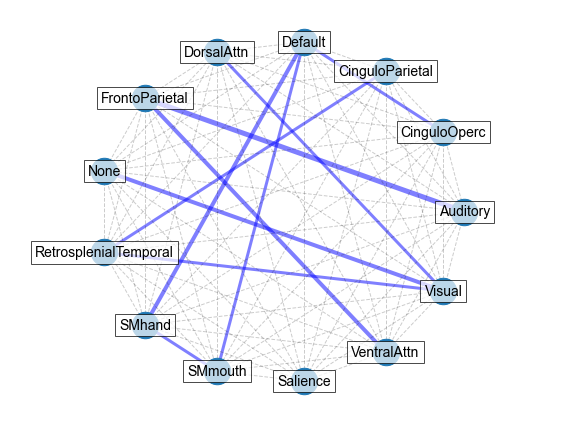

In [929]:
if atlas == 'dosenbach2010':
    n_nodes = 6
elif atlas == 'gordon2014_2mm':
    n_nodes = 13

print(atlas,connectivity)

shap_values_2d = np.zeros((n_nodes, n_nodes))
shap_values_2d_triu_indices = np.triu_indices(n_nodes, k=0)
shap_values_2d[shap_values_2d_triu_indices] = np.abs(shap_values.values).mean(0)
shap_values_2d = shap_values_2d + shap_values_2d.T - np.diag(np.diag(shap_values_2d))

# adj_df = pd.DataFrame(shap_values_2d)
feature_names_2d = get_feature_labels(atlas, connectivity, aggregated)
shap_2d = pd.DataFrame(shap_values_2d,
                       columns=feature_names_2d.columns,
                       index=feature_names_2d.index)

# sns.heatmap(shap_2d)
# plt.show()

import networkx as nx
G = nx.from_pandas_adjacency(shap_2d)

pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
label_options = {'ec': 'k', 'fc': 'white', 'alpha': 0.7}
nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)


# edges
_thr = 0.035
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > _thr]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= _thr]

edge_labels = nx.get_edge_attributes(G, 'weight')
# edge_weights = [int(i*100) for in in edge_labels]
edge_weights = [int(d['weight']*100) for (u, v, d) in G.edges(data=True) if d['weight'] >= _thr]
print(edge_weights)
nx.draw_networkx_edges(G, pos,
                       edgelist=elarge,
                       alpha=.5,
                       edge_color="b",
                       width=edge_weights)
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, alpha=0.2, edge_color='black', style='dashed')
# # nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)

# plot the graph
plt.rcParams["figure.figsize"] = (8,6)
plt.gca().margins(.2, 0.05)
plt.tight_layout()
plt.axis("off")
plt.show()

0.642 [ 184 2441 3269  652   38  273  219 1388  110 2609  911 2358 1132 2558
 2367 1520 2135 2700 1183   90  926  527 3318 1690 2998 2899 1204   91
 2740 2979  606  492 2826  416 2734 1320  295  349 3743 2048 2881 3688
 1094 2540 1076  861 1631 3517 1540  699 2911  101 3893 2062 2845 2326
 2564 2990  624 3120  163 1629  487 2553 1951 1440 3537 3098 1414 1471
 1728  400 1822 3555 2076 1778 3113 3486 1650  954 1318 2842 2424  609
 1637 2886 3839 2325  705 3511  440 3390 3151 3650 2240 2428 2055 1956
 2551 2029]


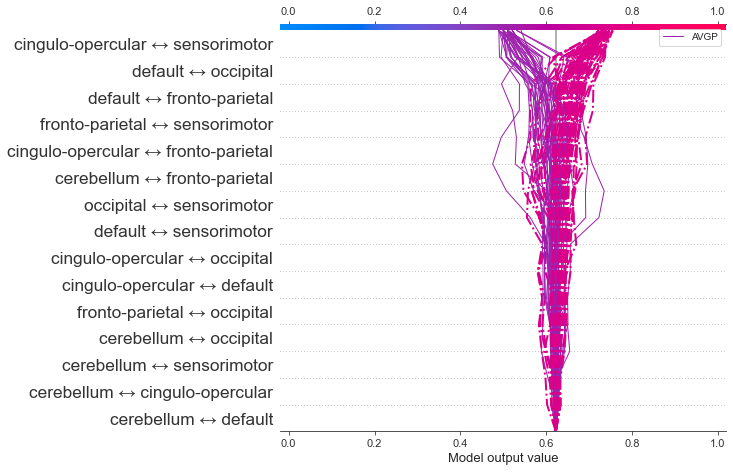

In [555]:
n_samples = 100
select_mask = np.where(y_pred == y_test)[0]     # correctly classified
# select_mask = np.where(y_pred != y_test)[0]   # misclassified
# select_mask = np.where(y_pred)[0]             # predicted class
# select_mask = np.where(y_test)[0]             # true class

select_mask = shap.utils.sample(select_mask, n_samples, random_state=None)

print((y_pred == y_test).mean(), select_mask)  # TODO show subject labels
highlight_mask = (y_test[select_mask] == 1)

def legend_labels(idx):
  return [y_encoder.classes_[i] for i in idx.astype(int)]

shap.plots.decision(.5, #np.mean(expected_value_cv),
                    shap_values.values[select_mask],
                    link='logit',
                    # feature_order='hclust',
                    # highlight=misclassified,
                    # ignore_warnings=True,
                    legend_labels=legend_labels(highlight_mask)[:1],
                    highlight=highlight_mask,
                    show=False,
                    feature_display_range=slice(-1, -16, -1),
                    feature_names = feature_names.tolist())

plt.yticks(fontsize='xx-large')

# plt.suptitle(f'SHAP decision paths for {n_samples} correctly classified samples.\n'
#              'Solid lines are AVGPs, and dotted lines are NVGPs.\n'
#              'Connectivities are ordered by their SHAP importance in the sample.',
#              ha='left', x=-.3, fontsize=14)
plt.show()

# Extra

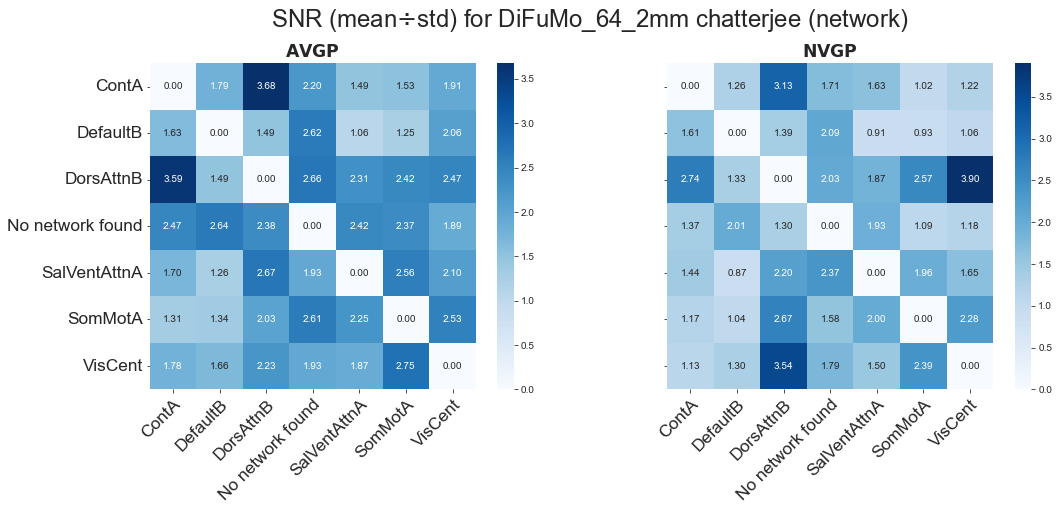

In [770]:

def plot_connectivity_heatmap(all_conns, title, plot_diff, ax):

    if plot_diff:
        avgp = conn.subject.str.contains("AVGP").values
        data = conn[avgp].mean(dim='subject').values - conn[~avgp].mean(dim='subject').values
    else:
        data_std = all_conns.values.std(axis=0)
        data_std  = np.where(np.isfinite(data_std), data_std, 0)
        data_std  = np.where(np.isnan(data_std), 0, data_std)
        data = all_conns.mean(dim='subject').values / data_std
        np.fill_diagonal(data, 0)

    sns.heatmap(
        data,
        yticklabels=conn.coords['node'].values,
        xticklabels=conn.coords['node'].values,
        annot=True, fmt='.2f',
        ax=ax,
        square=True,
        # vmax=data.max(),
        # figsize=(7, 7),
        # dendrogram_ratio=0.001,
        # cbar_pos=(1., 0.3, 0.03, 0.6)
        cmap='Blues',
        annot_kws={"size":'medium'}
        # cbar=False,
    )
    ax.set_title(f'$\\bf{{{title}}}$', fontsize='xx-large')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize='xx-large')
    ax.set_yticklabels(ax.get_xticklabels(), rotation=0, ha='right', rotation_mode='anchor', fontsize='xx-large')


conn = extract_connectivity(atlas='difumo_64_2mm', connectivity='chatterjee')
avgp = conn.subject.str.contains("AVGP").values

fig, axes = plt.subplots(1, 2, figsize=(17, 6), sharey=True)
plot_connectivity_heatmap(conn[avgp], title='AVGP', plot_diff=False, ax=axes[0])
plot_connectivity_heatmap(conn[~avgp], title='NVGP', plot_diff=False, ax=axes[1])
# plot_connectivity_heatmap(conn[~avgp], title='AVGP - NVGP', plot_diff=True, ax=axes)

plt.suptitle('SNR (mean$\div$std) for DiFuMo_64_2mm chatterjee (network)', fontsize=24, y=1.01)
plt.show()

In [ ]:
chart = pg.Line(_self_close=False, _max=10)

for (network,subject),data  in network_timeseries['timeseries_mean'].iteritems():
  if network in ['Visual','FrontoParietal']:
    chart.add(network, data)

from IPython.display import SVG
SVG(chart.render())

## Again, a very dirty but quick EPI signal level in Cerebellum

Is it clear that there is an appreciable reduction of tSNR in the brainstem and cerebellum compared to the cerebrum, caused by lower mean signal and/or increased signal variance in the those regions (as measured by tSNR)?

In [ ]:
from nilearn import image, plotting, maskers
from tqdm  import tqdm
import nibabel as nib 
from pathlib import Path
import datalad.api as dlapi
import numpy as np
import pandas as pd

tsnr_images = []

# fmriprep
dataset = dlapi.Dataset('data/julia2018/derivatives/fmriprep_2020')
scan_imgs = Path(dataset.path).glob('sub-*/ses-rest/func/*_bold.nii.gz')
mask_imgs = Path(dataset.path).glob('sub-*/ses-rest/func/*-brain_mask.nii.gz')
# raw
# dataset = dlapi.Dataset('data/julia2018')
# scan_imgs  = Path(dataset.path).glob('sub-*/ses-rest/func/*_bold.nii.gz')


for img, mask_img in tqdm(zip(scan_imgs,  mask_imgs)):
  dlapi.get(img)
  dlapi.get(mask_img)

  img = nib.load(img)
  mask_img = nib.load(mask_img)

  masker = maskers.NiftiMasker(mask_img)
  masked_img = masker.fit_transform(img)
  masked_img = masker.inverse_transform(masked_img)

  data_avg = np.mean(masked_img.get_fdata(), axis=-1)
  data_std = np.std(masked_img.get_fdata(), axis=-1)
  tsnr = data_avg / data_std
  tsnr = np.where(data_std > 0.0, tsnr, 0.0)
  tsnr_img = nib.nifti1.Nifti1Image(tsnr, masked_img.affine)

  tsnr_images.append(tsnr_img)


In [ ]:
# only works on fmriprep 

from nilearn import image
import nibabel as nib

mean_tsnr_img = image.mean_img(tsnr_images)


plotting.plot_epi(mean_tsnr_img, cut_coords=(-21,-79,-33),
                    black_bg=False,
                    colorbar=True,
                    title=f'Mean tSNR across all subjects (dosenbach2010 inf cerebellum 150)',
)

In [ ]:
from nilearn.datasets import fetch_coords_dosenbach_2010

atlas = fetch_coords_dosenbach_2010(legacy_format=False)

labels = pd.DataFrame(atlas.labels)
labels['network'] = atlas.networks.reset_index(drop=True)
# atlas.networks
# atlas.rois
labels[['x','y','z']] =  atlas.rois.reset_index(drop=True)
cerebellum_rois = labels.query('network == "cerebellum"')
cerebellum_rois

In [ ]:

for _,roi,network,x,y,z  in cerebellum_rois.itertuples():
    plotting.plot_epi(mean_tsnr_img, colorbar=True,
                    # cut_coords=(18,-81,-32),
                    cut_coords=(x,y,z),
                    # cmap='cold_hot',
                    black_bg=False,
                    title=f'Mean tSNR across all subjects (dosenbach2010 {roi})',
                    cbar_tick_format='%.2f')
    plotting.show()

In [ ]:
for tsnr_img in tsnr_images:
    plotting.plot_epi(tsnr_img, colorbar=True,
                    # cut_coords=(0,-60,-25),
                    # cmap='cold_hot',
                    cbar_tick_format='%.2f')
    plotting.show()

## Dirty Network masker

In [ ]:
from nilearn import maskers, datasets, plotting, image, surface
import numpy as np
from python.acnets.parcellations import gordon

atlas = gordon.fetch_atlas()

maps_data = image.get_data(atlas['maps'])
atlas.labels['network'] = atlas.labels['network'].astype('category')
region2network_mapping = atlas.labels['network'].cat.codes + 1
region2network_mapping = region2network_mapping.to_dict()
# atlas.labels['network'].cat.categories
none_regions = atlas.labels.query('network == "None"').index
none_idx = atlas.labels['network'].cat.categories.to_list().index('None') + 1
map_r2n = lambda x: region2network_mapping[int(x)] if x not in [0,none_idx] else 0
maps_data = np.vectorize(map_r2n)(maps_data)

new_maps = image.new_img_like(atlas['maps'], maps_data)
new_maps.to_filename('a.nii.gz')

fsaverage = datasets.fetch_surf_fsaverage()

# plotting.plot_epi(new_maps, colorbar=True)
# plotting.plot_img(new_maps, colorbar=True)
# plotting.plot_roi(new_maps, title='Gordon Atlas', colorbar=True)

# aa = surface.vol_to_surf(new_maps, fsaverage.pial_left)

# plotting.view(fsaverage['pial_left'], roi_map=aa,
#                        hemi='left', view='lateral',
#                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                        darkness=.5)

plotting.view_img(new_maps, symmetric_cmap=False, black_bg=False).open_in_browser()

# plotting.view_surf(fsaverage.white_right, aa).open_in_browser()
# plotting.plot_glass_brain(new_maps, colorbar=True, annotate=True)
# plotting.plot_epi(net_maps,cut_coords=(0,-10,-55), colorbar=True)

In [767]:
# Cross-correlation (DEBUG)

import sklearn
sklearn.set_config(display='diagram')
grid

# import statsmodels.api as sm
# sm.tsa.stattools.ccf([1,2,3,4,5,6,7,8,0], [0,0,1,2,3,4,5,6,7], adjusted=True)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=100, random_state=None, test_size=0.25,
            train_size=None),
             estimator=Pipeline(steps=[('connectivity',
                                        FunctionTransformer(func=<function extract_connectivity at 0x135631430>)),
                                       ('vectorize', ConnectivityVectorizer()),
                                       ('svm',
                                        LinearSVC(C=0.1, max_iter=100000))]),
             param_grid={'connectivity__kw_args': [{'aggregate_networks': True,
                                                    'atlas': 'dosenbach2010',
                                                    'connectivity': 'correlation'},
                                                   {'aggregate_networks': True,
                                                    'atlas': 'dosenbach2010',
                                                    'connectivity': 'chatterjee'}]},
             scoring='accuracy', verbose=2)